In [1]:
using Plots

In [2]:
#some utilities for inputs

mutable struct InputParams
    pulsestarts::Array{Float64,1}
    pulsestops::Array{Float64,1}
    pulseheights::Array{Float64,1}
    pulsecounter::Int64
    pulsewindow::Int64
    input::Float64
end

function updateinput!(inputstructure::InputParams, currenttime)
    # inputstructure.pulsecounter initialized at 1
    if currenttime >= inputstructure.pulsestarts[inputstructure.pulsecounter] &&
        currenttime <= inputstructure.pulsestops[inputstructure.pulsecounter]

        inputstructure.input = inputstructure.pulseheights[inputstructure.pulsecounter]
        inputstructure.pulsewindow = 1
    end

    if inputstructure.pulsewindow == 1 &&
        currenttime > inputstructure.pulsestops[inputstructure.pulsecounter]

        inputstructure.pulsewindow = 0
        inputstructure.pulsecounter += 1
        inputstructure.input = 0.0
    end

    return nothing

end

updateinput! (generic function with 1 method)

# Figure 1 B,C

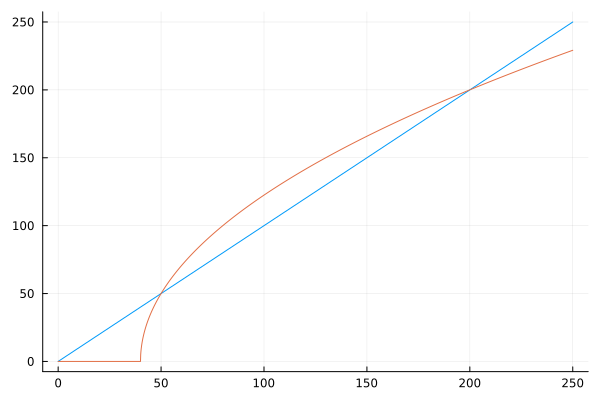

In [7]:
# Some parameters:
dt = 0.5; #ms
tmax = 2000;
tau_r = 150; #ms
w = 1.235*0.2025 #ms^-1
r_thresh = 40e-3; #ms^-1
SaccPeriod = 2100; #ms
SaccDuration = 50; #ms
rmax = 250 #Hz

pulsestarts = 10 #ms
pulsedurations = 50 #ms
pulseheights = 0.0 #going into loop below

r_plot_vect = 0:0.1:rmax;
r_fdbk_vect = sqrt.(max.(0,1000*w*(r_plot_vect .- 1000*r_thresh)));

fbkdecayplot = plot(legend=false); 
plot!(fbkdecayplot, [0,rmax], [0,rmax])
plot!(fbkdecayplot, r_plot_vect, r_fdbk_vect)

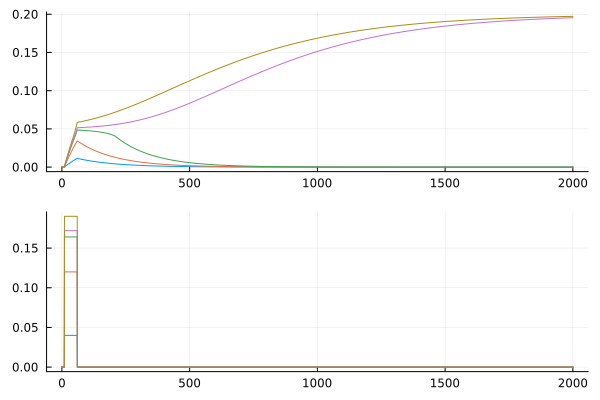

In [8]:
inputparams = InputParams(
                            vcat(pulsestarts, 1e23), #pulse starts plus a realmax pad to make things easy
                            vcat(pulsestarts + pulsedurations, 1e23),
                            vcat(pulseheights, 1e23),
                            1, #pulsecounter::Int64
                            0, #pulsewindow::Int64
                            0.0 #input::Float64, initialize at zero, gets updated during sim
                            )

t_vect = 0:dt:tmax
command_vect = 4*[0.01, 0.03, 0.041, 0.043, 0.0475]
tseries_storage_r = zeros(length(t_vect), length(command_vect))
tseries_storage_input = zeros(length(t_vect), length(command_vect))

tseries_rateplot = plot(legend=false);
tseries_inputplot = plot(legend=false);

for (idx1, CommandSize) in enumerate(command_vect)
    r = 0;
    inputparams.input = 0.0;
    inputparams.pulsecounter = 1;
    inputparams.pulsewindow = 0;
    inputparams.pulseheights = vcat(CommandSize, 1e23);
    
    for (idx2, t) in enumerate(t_vect)
        
        updateinput!(inputparams, t)
        
        
        r = sqrt(max(0,w*(r-r_thresh))) + 
                inputparams.input + 
                (r - sqrt(max(0,w*(r-r_thresh))) - 
                inputparams.input)*exp(-dt/tau_r);
        
        tseries_storage_input[idx2,idx1] = inputparams.input;
        tseries_storage_r[idx2,idx1]= r;

    end
    
    plot!(tseries_rateplot, t_vect, tseries_storage_r[:,idx1])
    plot!(tseries_inputplot, t_vect, tseries_storage_input[:,idx1])
    
end


plot(tseries_rateplot, tseries_inputplot, layout = (2,1))

# Figure 1D,E

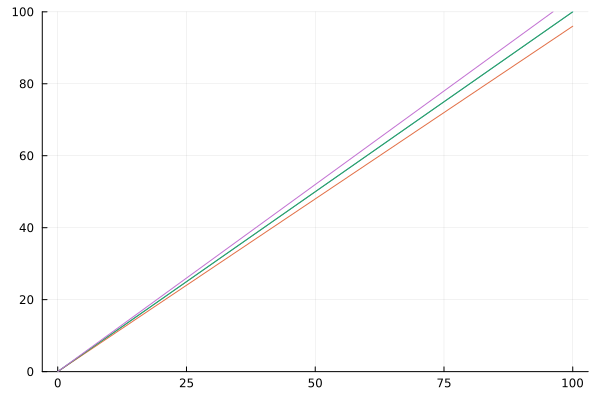

In [5]:
#params:
dt = 0.5; #ms
tmax = 10000;
tau_r = 150; #ms
rmax = 100; #Hz
autapseweight_vect = [.96, 1, 1.04]

# Inputs:
pulsestarts = [100,2000,4000,6000,8000] #ms
pulsedurations = 50*ones(length(pulsestarts)) #ms
pulseheights_low = [0.07, 0.07, 0.07, -0.02, -0.02] #going into loop below
pulseheights_tuned = [0.05, 0.05, 0.05, -0.04, -0.04]
pulseheights_high = [0.03, 0.03, 0.03, -0.13, -0.13]

fbkdecayplot = plot(ylims=(0,100), legend=false);

plot!(fbkdecayplot, [0,rmax], [0,rmax])

for w in autapseweight_vect
    plot!(fbkdecayplot, [0,rmax], [0, w*rmax])
end

plot(fbkdecayplot)

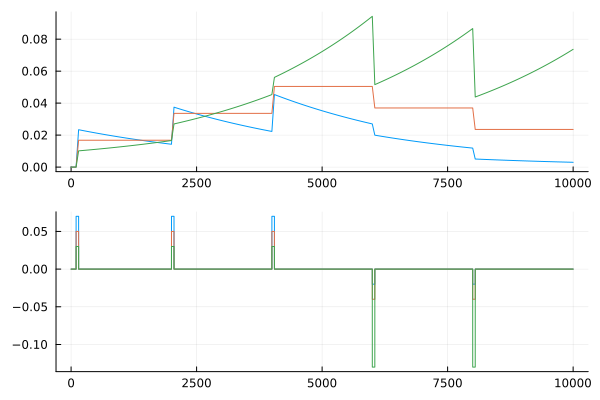

In [6]:
t_vect = 0:dt:tmax

pulseheights = hcat(pulseheights_low, pulseheights_tuned, pulseheights_high)

inputparams = InputParams(
                            vcat(pulsestarts, 1e23), #pulse starts plus a realmax pad to make things easy
                            vcat(pulsestarts + pulsedurations, 1e23),
                            vcat(zeros(length(pulseheights_low)), 1e23),
                            1, #pulsecounter::Int64
                            0, #pulsewindow::Int64
                            0.0 #input::Float64, initialize at zero, gets updated during sim
                            )

tseries_storage_r = zeros(length(t_vect), size(pulseheights,2))
tseries_storage_input = zeros(length(t_vect), size(pulseheights,2))

tseries_rateplot = plot(legend=false);
tseries_inputplot = plot(legend=false);

for (idx1, autapseweight) in enumerate(autapseweight_vect)
    r = 0;
    inputparams.input = 0.0;
    inputparams.pulsecounter = 1;
    inputparams.pulsewindow = 0;
    inputparams.pulseheights = vcat(pulseheights[:,idx1], 1e23);
    
    for (idx2, t) in enumerate(t_vect)
        
        updateinput!(inputparams, t)
        
        r = autapseweight*r + inputparams.input + 
            (r - autapseweight*r - inputparams.input)*exp(-dt/tau_r);
        
        tseries_storage_input[idx2,idx1] = inputparams.input;
        tseries_storage_r[idx2,idx1]= r;

    end
    
    plot!(tseries_rateplot, t_vect, tseries_storage_r[:,idx1])
    plot!(tseries_inputplot, t_vect, tseries_storage_input[:,idx1])
    
end


plot(tseries_rateplot, tseries_inputplot, layout = (2,1))